# Time Series Analysis of the Blitz Rating on Lichess for ArturoArias

**By: Arturo Alfredo Arias Aguilar**

**Course: Time Series**

**Program: Data Science Specialization**

**Institution: Data Science Research Peru**

**2025**

## Installation of required modules

To apply auto-ARIMA later on, it is necessary to install `pmdarima`. This package works correctly with any version of `numpy` prior to version 2, which is why the preinstalled version in the Google Colab environment is uninstalled and the most recent version prior to 2 is installed. After that, `pmdarima` is installed.

When running the notebook again and reinstalling `numpy`, it may be necessary to restart the session. If that message appears, simply restart it and continue executing the code from the data-loading section onward.

In [1]:
# Reinstalling numpy
!pip uninstall -y numpy
!pip install "numpy<2"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=

In [1]:
# Installing pmdarima
!pip install pmdarima
import pmdarima as pm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 12.3 MB/s eta 0:00:00


## Data collection

The data for this analysis is obtained using the Lichess API.

The raw data is returned as a JSON structure corresponding to the rating history across different game modes. It consists of an array (list) of objects, where each object represents a specific game mode (for example, “Bullet”, “Blitz”, etc.). Each object contains two main keys: `name`, which corresponds to the name of the game mode, and `points`, which is an array of integer values formatted as `[year, month, day, rating]`. By filtering to keep only the entries associated with the Blitz mode, a DataFrame can be constructed for further analysis.

In [2]:
import requests
import pandas as pd
from datetime import datetime

# My Lichess username
username = "ArturoArias"
url = f"https://lichess.org/api/user/{username}/rating-history"

# Retrieve the data from the API
response = requests.get(url) # HTTP request (GET request)
rating_data = response.json()

# Filter to keep only Blitz
blitz_data = next(item for item in rating_data if item["name"].lower() == "blitz")

# Extract the data as a list
ratings = blitz_data["points"]

# Convert to DataFrame
df_blitz = pd.DataFrame(ratings, columns=["year", "month", "day", "rating"])

# Create date column
def ymd_to_date_str(year, month, day):
    return f'{year}-{month+1}-{day}' # In the raw data, the months range from 0 to 11
for i in range(len(df_blitz)):
    try:
        df_blitz.loc[i, "date"] = pd.to_datetime(ymd_to_date_str(df_blitz.loc[i, "year"], df_blitz.loc[i, "month"], df_blitz.loc[i, "day"]))
    except:
        continue

# Keep only the 'date' and 'rating' columns
df_blitz = df_blitz[["date", "rating"]]

# Filter the date range and set the date as the index
df_blitz = df_blitz[(df_blitz['date'] >= '2024-01-01') & (df_blitz['date'] <= '2024-07-5')]
df_blitz.set_index('date', inplace=True)

# Display the DataFrame
print(df_blitz.info(), end='\n\n')
print(df_blitz.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2024-01-01 to 2024-07-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   rating  177 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB
None

            rating
date              
2024-01-01    1811
2024-01-02    1827
2024-01-03    1832
2024-01-04    1808
2024-01-05    1827


A total of 177 data points are recorded for the period between January 1 and July 5, 2024. This range was selected because it corresponds to a period of consistent activity on Lichess, during which a continuous flow of data is available.

In [3]:
# Descriptive statistics
df_blitz.describe()

,rating
count,177.000000
mean,1787.790960
std,39.341545
min,1710.000000
25%,1757.000000
50%,1785.000000
75%,1813.000000
max,1885.000000


## Preliminary visualization

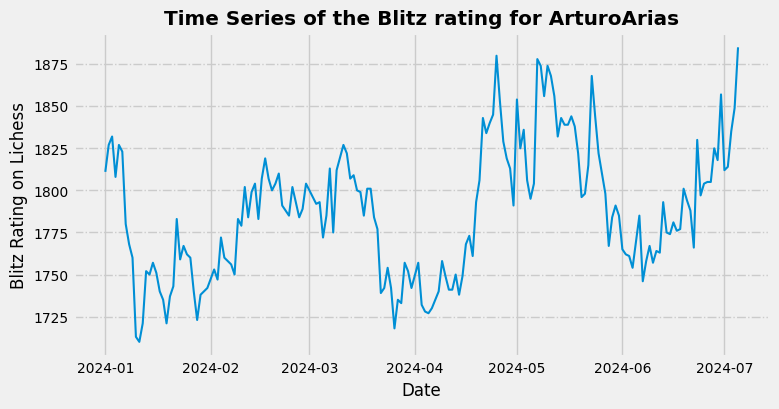

In [6]:
import matplotlib.pyplot as plt

# Generate time series plot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
plt.figure(figsize=(8,4))
plt.plot(df_blitz['rating'])
plt.xlabel('Date')
plt.ylabel('Blitz Rating on Lichess')
plt.title('Time Series of the Blitz rating for ArturoArias', fontweight='bold')
plt.grid(axis='y', linestyle='dashdot', linewidth=1)
plt.show()

Based on the observed plot:

- Trend: **Increasing**.
- Stationarity: **Non-stationary**.
- Seasonality: **Non-seasonal**.

## Classical decomposition of the series

The Blitz rating time series is separated into three additive components (trend, seasonality, and residual) to identify the long-term trend, detect seasonal patterns, and extract the residuals. This helps to better understand the structure of the series, determine the necessary transformations (such as differencing or seasonal adjustment), and ensure that the final model aligns more effectively with the component intended for forecasting.

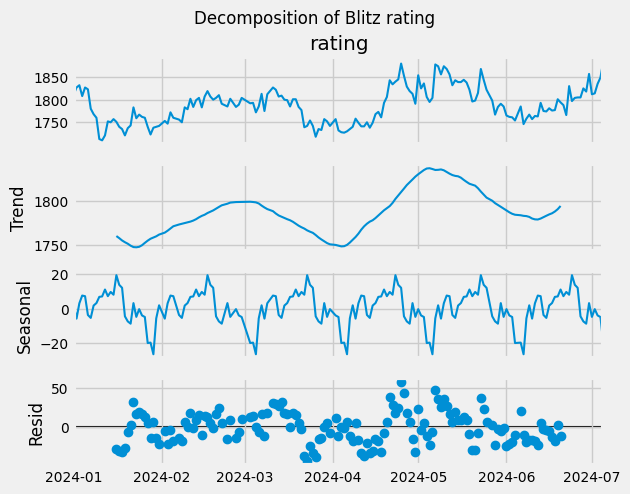

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_blitz['rating'].interpolate(), model='additive', period=30)
decomp.plot()
plt.suptitle('Decomposition of Blitz rating', y=1.02)
plt.show()

- The trend component shows a slight decline from January to late February, followed by a pronounced increase in March-April and a small correction toward June, confirming the overall upward trend observed.

- The seasonality plot reveals recurrent oscillations of roughly 15 to 20 points with a periodicity close to one month, suggesting a "monthly" cycle in your Blitz activity (for example, streaks of games near the beginning or end of each month). Although moderate in amplitude, this component confirms the presence of a weak but systematic seasonal pattern.

- The residual values fluctuate randomly around zero with no apparent structure and display homogeneous variance over time. This indicates that most of the variability in the series is captured by the trend and seasonality components, and that the residuals are ready for stationary modeling (for example, through differencing or ARIMA).

## Stationarity tests

### Autocorrelation (ACF y PACF)

To explore the serial dependence of the Blitz rating time series in greater depth, both the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) are computed and plotted. The ACF measures the correlation between the value of the series at time $t$ and its value at time $t-k$ for different lags $k$. In this case, lags up to 40 days are analyzed, allowing us to evaluate how many days apart still exhibit significant correlation with the current rating. By examining the ACF coefficients, we can determine whether the series shows persistence (high autocorrelation values across several lags) or whether it decays quickly toward zero, which would indicate stationarity after appropriate transformations.

The PACF, on the other hand, measures the direct correlation between the series at time $t$ and $t-k$, removing the influence of all intermediate lags. Its plot, shown here up to 25 lags, helps identify the precise order $p$ of the autoregressive component in an ARIMA model. A sharp cutoff in the PACF after a certain lag (for example, after $k=1$ or $k=2$) suggests that only those initial lags contribute independent information to the model.

In practice, these two plots are essential for selecting the parameters $p$ (order of the AR component) and $q$ (order of the MA component) in an ARIMA model.


<Figure size 800x400 with 0 Axes>

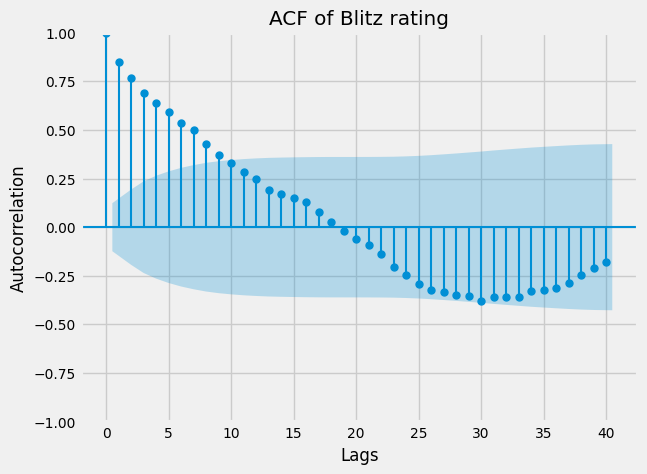

<Figure size 800x400 with 0 Axes>

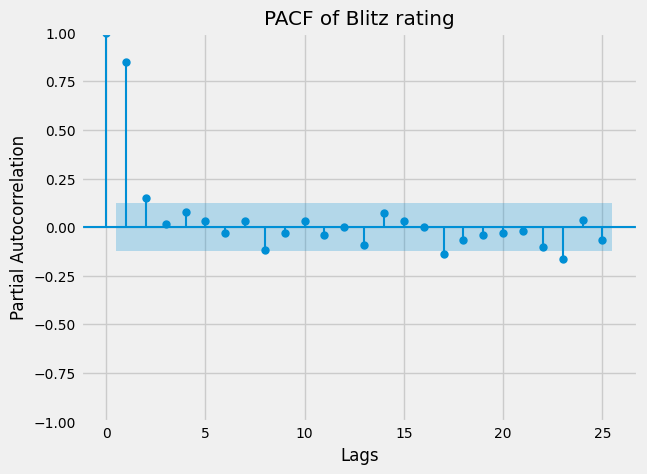

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF
plt.figure(figsize=(8,4))
plot_acf(df_blitz['rating'].dropna(), lags=40, alpha=0.1)
plt.title('ACF of Blitz rating')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF
plt.figure(figsize=(8,4))
plot_pacf(df_blitz['rating'].dropna(), lags=25, alpha=0.1)
plt.title('PACF of Blitz rating')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

he ACF shows very high autocorrelations at the first lags (approximately 0.9 at
k=1), followed by a slow and gradual decay. According to the criterion that a series is considered non-stationary if its ACF does not decay toward zero before lag 15-20, the ACF therefore indicates the non-stationarity of the series.

In the PACF, a single significant spike appears at lag 1 (approximately 0.9), and from lag 2 onward the values fall within the confidence bands. According to the AR(p) identification rule (p is the number of non-zero lags in the PACF), this pattern suggests an AR(1) model to capture the direct serial dependence.

### Variogram

In this section, the variogram of the Blitz rating series is computed and plotted.

The ACF is calculated, the variogram is constructed, and it is then plotted together with the theoretical asymptote to which $G_k$ should converge if the series were stationary.

Asymptote: 6.764113943475322


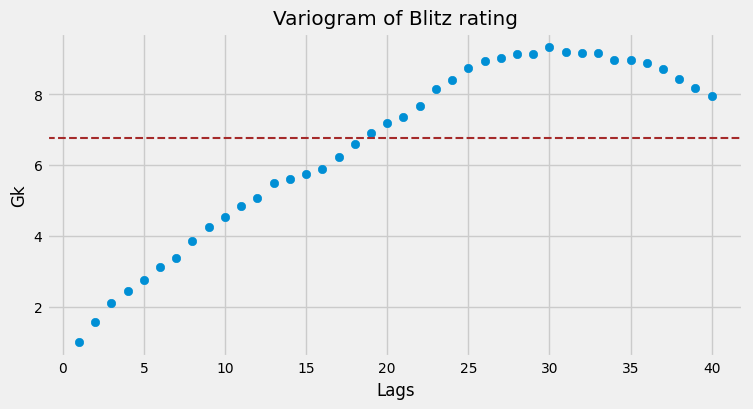

In [8]:
from statsmodels.tsa.stattools import acf

# Variogram
v_acf = acf(df_blitz['rating'].dropna(), fft=False, nlags=40)
lags = list(range(1, 41))
Gk = [(1 - v)/ (1 - v_acf[1]) for v in v_acf[1:]]
plt.figure(figsize=(8,4))
plt.scatter(lags, Gk)
plt.axhline(1/(1 - v_acf[1]), color='brown', linestyle='--')
plt.title('Variogram of Blitz rating')
plt.xlabel('Lags')
plt.ylabel('Gk')
print(f'Asymptote: {1/(1 - v_acf[1])}')
plt.show()

The variogram shows that $G_k$ increases until it surpasses the asymptote ($\approx$6.76) at around k $\approx$ 19. The lack of convergence of $G_k$ again confirms the **non-stationarity** of the series.

After reaching a maximum at k=30, $G_k$ begins to decline, but without stabilizing at the asymptote. This suggests that although long-term dependencies exist, the series does not exhibit a clear memory limit that would make it stationary without differencing.

Taken together, this behavior of the variogram reinforces the need to difference the series before fitting any ARIMA or smoothing model.

### Dickey-Fuller Test

The Dickey-Fuller test is also used to evaluate the stationarity of the series. According to the theory, the null hypothesis ($H_0$) of this test states that the series is non-stationary, while the alternative hypothesis ($H_1$) states that it is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller test
result = adfuller(df_blitz['rating'].dropna())
print('ADF Statistic:      %f' % result[0])
print('p-value:            %f' % result[1])
print('Critical Values:')
for key, val in result[4].items():
    print(f'   {key}: {val:.3f}')

ADF Statistic:      -2.481848
p-value:            0.119954
Critical Values:
   1%: -3.468
   5%: -2.878
   10%: -2.576


The test statistic (-2.481) is higher than the 5% critical value (-2.878), which already suggests that the null hypothesis should not be rejected.

Moreover, the p-value (0.12) is greater than all conventional significance thresholds (0.01, 0.05, and 0.10), implying that **the null hypothesis of non-stationarity cannot be rejected**.

Thus, the series is once again confirmed to be **non-stationary**.

## Differencing of the series

The non-stationarity of the Blitz rating series, characterized by increasing variance over time and long-term memory, was previously established. To remove this trend and approximate stationarity, a first-order differencing transformation is applied.

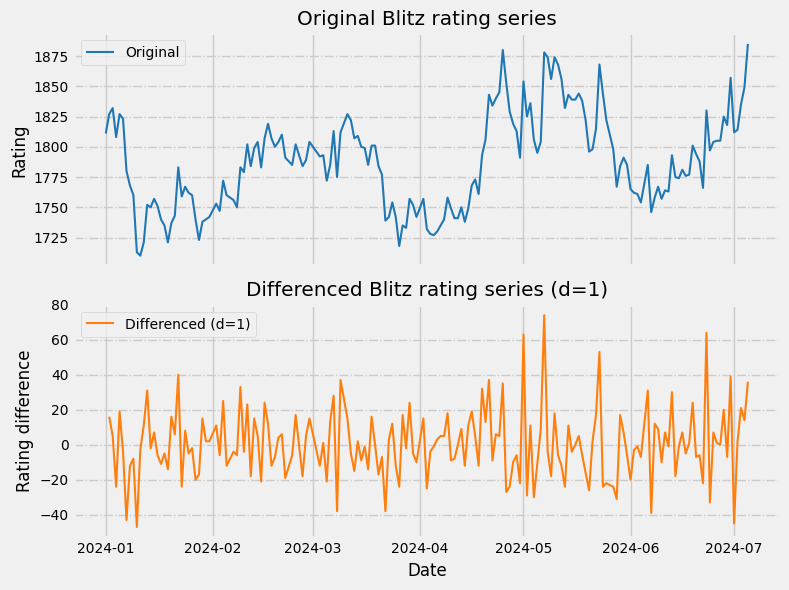

In [9]:
# Create the differenced series
df_blitz['rating_diff1'] = df_blitz['rating'].diff()

# Two subplots: original and differenced
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Subplot 1: Original series
axes[0].plot(df_blitz['rating'], label='Original', color='tab:blue')
axes[0].set_title('Original Blitz rating series')
axes[0].set_ylabel('Rating')
axes[0].grid(axis='y', linestyle='dashdot')
axes[0].legend()

# Subplot 2: Differenced series
axes[1].plot(df_blitz['rating_diff1'], label='Differenced (d=1)', color='tab:orange')
axes[1].set_title('Differenced Blitz rating series (d=1)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Rating difference')
axes[1].grid(axis='y', linestyle='dashdot')
axes[1].legend()

plt.tight_layout()
plt.show()

It is observed that the differenced series oscillates around zero with no visible slope, indicating that the trend component has been effectively removed. Differencing centers the values around zero (with a mean close to zero). Although peaks remain (corresponding to abrupt changes in rating) the magnitude of these oscillations is considerably more homogeneous over time than in the original series. These trend-free “jumps” suggest that the differenced series approximates a short-term dependence structure, suitable for modeling with an ARIMA(1,1,0) model or a similar specification, as indicated earlier by the PACF, which displayed only a single significant lag at k=1.

## ACF and PACF of the Differenced Series

Once the series has been differenced (d = 1), its ACF and PACF are plotted again in order to verify that, after removing the trend, the transformed series behaves as a stationary process and to identify the appropriate orders $p$ and $q$ for an ARIMA model.

<Figure size 800x400 with 0 Axes>

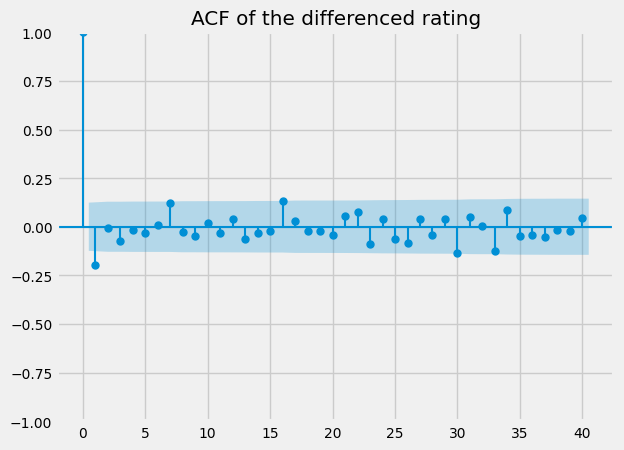

<Figure size 800x400 with 0 Axes>

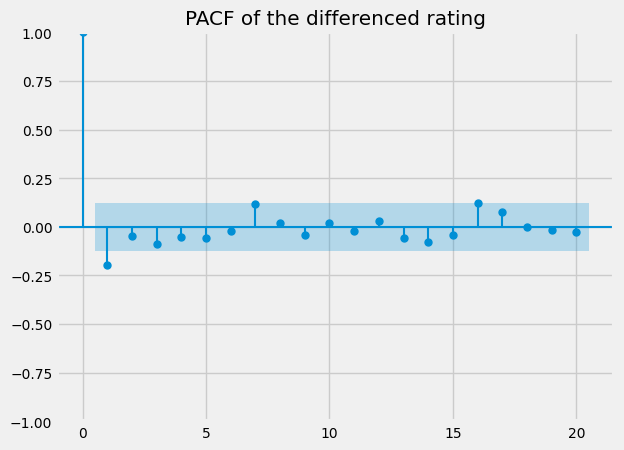

In [10]:
plt.figure(figsize=(8,4))
plot_acf(df_blitz['rating_diff1'].dropna(), lags=40, alpha=0.1)
plt.title('ACF of the differenced rating')
plt.show()

plt.figure(figsize=(8,4))
plot_pacf(df_blitz['rating_diff1'].dropna(), lags=20, alpha=0.1)
plt.title('PACF of the differenced rating')
plt.show()

It can be observed that, except for lag 1 (which typically displays a negative spike due to differencing), **all autocorrelation coefficients fall rapidly within the confidence bands**. This rapid decay and confinement within the interval indicate that there is no substantial moving average component beyond a possible **MA(1)**. PFurthermore, the partial autocorrelation plot exhibits a single significant spike at lag 1, with no additional lags exceeding the confidence bounds. According to the rule for selecting the AR order ($p$ is the number of non-zero lags in the PACF), this pattern suggests an **AR(1)** autoregressive component.

Therefore, for the ARIMA model, $d=1, p=1$ and $q=0$. An ARIMA(1,1,0) is a reasonable starting point.

## Smoothing and rapid forecasting

### Simple moving average

The moving average computes the mean of the last $n$ values at each point, removing a substantial portion of short-term variability. In this case, a weekly window (7 days) is applied.

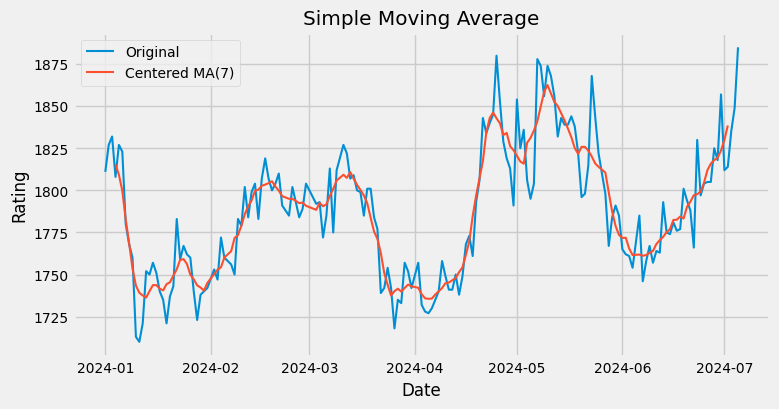

In [11]:
window = 7
df_blitz[f'MA_{window}'] = df_blitz['rating'].rolling(window=window, center=True).mean()

plt.figure(figsize=(8,4))
plt.plot(df_blitz['rating'], label='Original')
plt.plot(df_blitz[f'MA_{window}'], label=f'Centered MA({window})')
plt.title('Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.legend()
plt.show()

The moving average line smooths out abrupt peaks and troughs, making the overall evolution of the series more apparent. Instead of examining day-to-day fluctuations, it becomes possible to observe directional changes similar to those indicated by the trend plot.

### Forecasting using the moving average

To evaluate the effectiveness of the moving average as a forecasting method, the smoothed series generated with a 7-day window is used. The time series is divided into training and testing sets (80/20). For each subset, missing values are removed, and the mean squared error ($MSE$) is computed between the actual values and those produced by the moving average.

In [14]:
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Function to compute the MSE of the moving average
def mseData(dataf, varInt, window_size):
  dataf = dataf.copy()
  dataf['rolling_mean'] = dataf[varInt].rolling(window=window_size).mean()
  # Remove NaN values generated by the moving average
  dataf.dropna(inplace=True)
  # Compute the MSE between the actual values and the prediction
  return mean_squared_error(dataf[varInt], dataf['rolling_mean'])

# Split the data into sets (80% train / 20% test)
train_size = 0.8
split_index = int(len(df_blitz) * train_size)
df_blitz_train = df_blitz[:split_index]
df_blitz_test  = df_blitz[split_index:]

# Calculate and print MSE
mse_train = mseData(df_blitz_train, 'rating', window)
print(f'Train Mean Squared Error MA({window}): {mse_train:.2f}')

mse_test = mseData(df_blitz_test, 'rating', window)
print(f'Test  Mean Squared Error MA({window}): {mse_test:.2f}')

Train Mean Squared Error MA(7): 499.94
Test  Mean Squared Error MA(7): 233.70


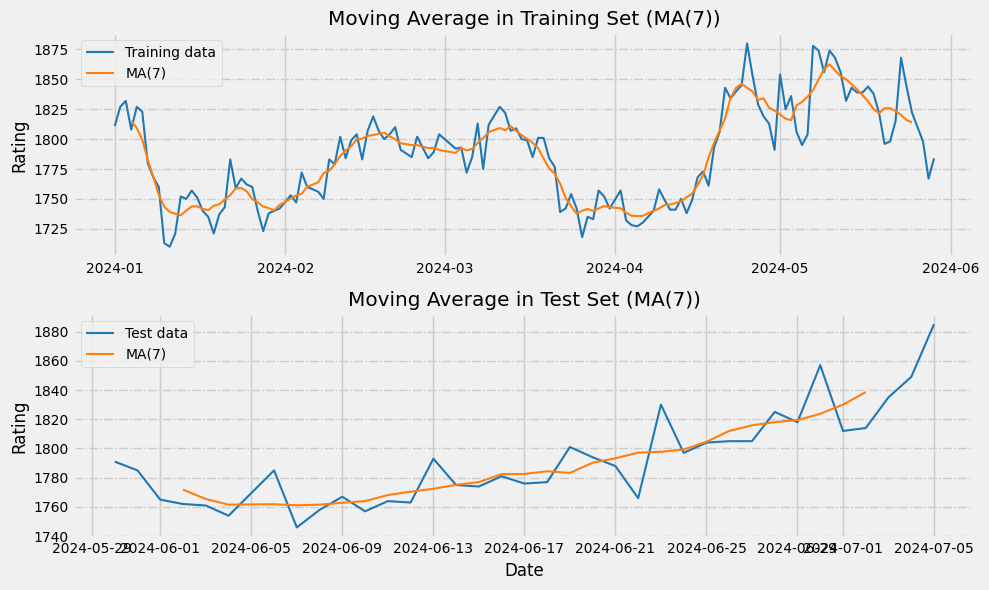

In [15]:
# MA in train and test
df_train = df_blitz_train.copy()
df_train['MA'] = df_train['rating'].rolling(window=window, center=True).mean()

df_test  = df_blitz_test.copy()
df_test ['MA'] = df_test ['rating'].rolling(window=window, center=True).mean()
# Plot in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# Train
ax1.plot(df_train.index, df_train['rating'], label='Training data', color='tab:blue')
ax1.plot(df_train.index, df_train['MA'],     label=f'MA({window})',   color='tab:orange')
ax1.set_title(f'Moving Average in Training Set (MA({window}))')
ax1.set_ylabel('Rating')
ax1.grid(axis='y', linestyle='dashdot')
ax1.legend()

# Test
ax2.plot(df_test.index, df_test['rating'], label='Test data', color='tab:blue')
ax2.plot(df_test.index, df_test['MA'],      label=f'MA({window})',  color='tab:orange')
ax2.set_title(f'Moving Average in Test Set (MA({window}))')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rating')
ax2.grid(axis='y', linestyle='dashdot')
ax2.legend()

plt.tight_layout()
plt.show()

The MSE in the training set is notably higher than in the validation set. This indicates that the moving average oversmooths the data during periods of high variability in the training phase (March-April), where rating jumps were more abrupt. In contrast, during the testing phase (May-June), the series exhibited lower volatility, and therefore the MA(7) forecast is more accurate.

The moving average with a 7-day window effectively captures moderate changes in trend, but it does not adequately represent sharp peaks. Its performance depends strongly on the volatility of the segment being analyzed. As a baseline method, it provides a useful point of comparison before applying more sophisticated techniques (SES, Holt, ARIMA, LSTM) that may better adapt to the dynamics of the Blitz rating series.

### Simple Exponential Smoothing (SES)

In simple exponential smoothing (SES), each new smoothed value $S_t$ is computed as a linear combination of the observed value $y_t$ and the previous smoothed value $S_{t-1}$:

$$
S_t = \alpha y_t + (1 - \alpha) S_{t-1}
$$

Where $\alpha$ is the smoothing parameter that determines the weight assigned to the most recent observation. The initial value $S_0 = y_0$ is set equal to the first value of the series.

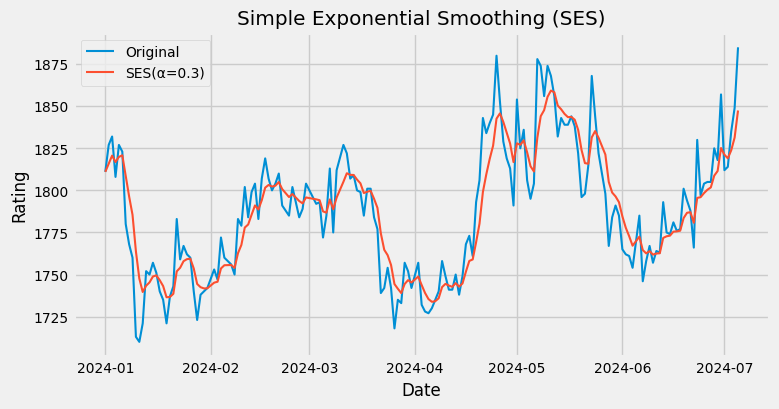

In [16]:
def exp_smooth(series, alpha):
    result = [series.iloc[0]]
    for v in series.iloc[1:]:
        result.append(alpha*v + (1-alpha)*result[-1])
    return pd.Series(result, index=series.index)

alpha = 0.3
df_blitz[f'SES_{alpha}'] = exp_smooth(df_blitz['rating'].dropna(), alpha)

plt.figure(figsize=(8,4))
plt.plot(df_blitz['rating'], label='Original')
plt.plot(df_blitz[f'SES_{alpha}'], label=f'SES(α={alpha})')
plt.title('Simple Exponential Smoothing (SES)')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.legend()
plt.show()

The SES curve attenuates much of the more abrupt day-to-day fluctuations, producing a clearer profile of the underlying trends. The smoothing process does not take long to adjust to an upward movement (for example, in April-May), nor does it immediately discard a peak, which provides a balance between responsiveness and noise reduction. Compared with the moving average, SES can react more rapidly to level changes because its formula incorporates previous observations in an exponential manner. This can be observed in how the orange line follows the increases in mid-April and June with greater fidelity.

An $\alpha$ value closer to 1 would make the smoothed series almost as noisy as the original data, whereas a value close to 0 would produce a very flat curve. The selected value of 0.3 reflects a reasonable balance between stability and responsiveness.

### Holt's method

Holt's method extends simple exponential smoothing by incorporating an additive trend component.

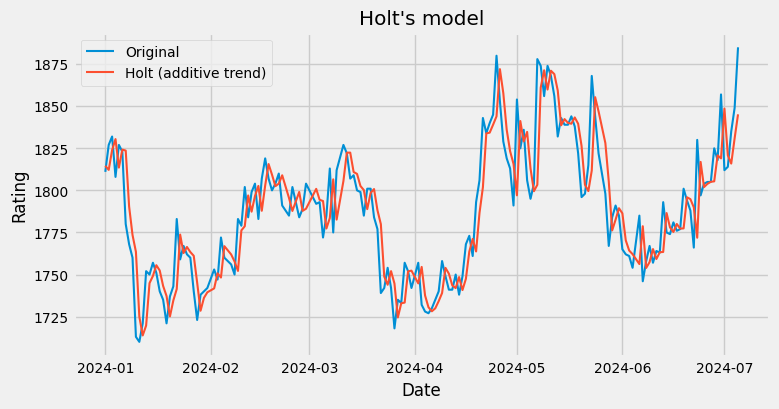

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt = ExponentialSmoothing(df_blitz['rating'].dropna(), trend='add', seasonal=None)
fit_holt = holt.fit()

plt.figure(figsize=(8,4))
plt.plot(df_blitz['rating'], label='Original')
plt.plot(fit_holt.fittedvalues, label='Holt (additive trend)')
plt.title("Holt's model")
plt.xlabel('Date')
plt.ylabel('Rating')
plt.legend()
plt.show()

The fitted line closely follows both abrupt peaks and prolonged declines (for example, the sharp increase in April and the initial rise in July). Compared with simple exponential smoothing, Holt’s method responds more rapidly to sustained changes because it dynamically adjusts the slope. Although small fluctuations persist, the model filters a substantial portion of short-term noise and reveals the medium-term behavior of the series. These fitted values serve as the starting point for future forecasts.

### Forecasting with Holt's method

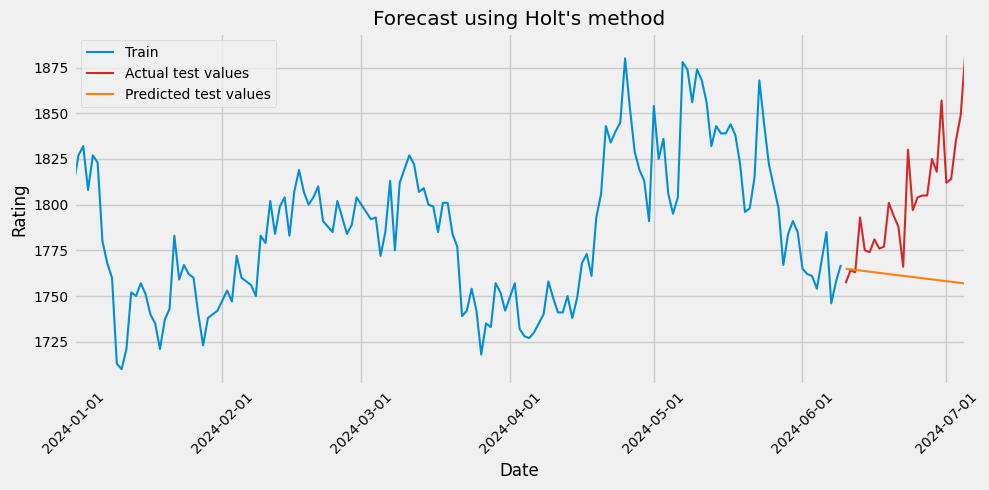

In [18]:
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Hold-out validation: last N points
N = int(len(df_blitz)*0.15)
train_h = df_blitz['rating'][:-N]
test_h  = df_blitz['rating'][-N:]

# Fit Holt’s method and generate predictions
model_h = ExponentialSmoothing(train_h.dropna(), trend='add', seasonal=None).fit() # Used dropna()
raw_pred = model_h.forecast(steps=N)

# Assign the correct index to the raw predictions
pred_h = pd.Series(raw_pred.values, index=test_h.index) # Used raw_pred.values

# Plot with a restricted X-axis and formatted dates
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_h.index, train_h,   label='Train')
ax.plot(test_h.index,  test_h,    label='Actual test values', color='tab:red')
ax.plot(pred_h.index,  pred_h,    label='Predicted test values', color='tab:orange')

ax.set_title("Forecast using Holt's method")
ax.set_xlabel('Date')
ax.set_ylabel('Rating')

ax.set_xlim(train_h.index.min(), test_h.index.max())

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

ax.legend()
plt.tight_layout()
plt.show()

The resulting forecast (orange line) decreases slightly because Holt's method estimates that the trend in the final days of the training period is downward. It is evident that the model does not follow the sharp increase in rating observed in May-June (red line), which suggests that the model, by relying on smoothed estimates of level and slope, fails to capture the most recent upward momentum. This occurs because, in Holt's method, if the series declines or stabilizes near the end of the training window, the forecast inherits the negative sign of that estimated slope.

In conclusion, Holt's forecast is useful for capturing smooth trends, but it may underperform when the series exhibits abrupt shifts, as in this case, because its trend component represents a discounted average of past changes.

As a baseline, it provides a reference point for subsequent comparison with models such as ARIMA or LSTM, which may adapt more effectively to sudden accelerations.

## Modelado ARIMA

In this section, ARIMA models (Autoregressive Integrated Moving Average) are applied to explicitly capture the autoregressive dynamics, the differencing (integration) required to achieve stationarity, and the moving average component that represents serially correlated noise. An ARIMA(p,d,q) model combines the following elements:

- AR(p): the current value expressed as a regression on its $p$ lagged values.
- I(d): the number of differences applied to remove the trend and achieve stationarity
- MA(q): the noise term modeled through a moving average of order $q$.

### Train-Validation-Test split

The series is divided into training (70%), validation (15%), and test (15%) subsets in order to fit the model and evaluate its out-of-sample performance.

In [20]:
n = len(df_blitz)
n_train = int(n * 0.7)
n_valid = int(n * 0.15)

train = df_blitz['rating'].iloc[:n_train]
valid = df_blitz['rating'].iloc[n_train:n_train+n_valid]
test  = df_blitz['rating'].iloc[n_train+n_valid:]

### ARIMA with manual search (grid search)

To empirically identify the optimal parameters, a grid search with walk-forward validation is implemented. This procedure emulates "moving through time" by adding each actual observation after it is predicted, thereby evaluating the forecasting error without retraining on the entire validation set.

Best ARIMA(p,d,q)= (2, 0, 0) MSE= 857.5411215689799
                               SARIMAX Results                                
Dep. Variable:                 rating   No. Observations:                  123
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -535.695
Date:                Thu, 11 Dec 2025   AIC                           1079.389
Time:                        07:31:26   BIC                           1090.638
Sample:                             0   HQIC                          1083.959
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1790.4014     19.426     92.167      0.000    1752.328    1828.475
ar.L1          0.7829      0.099      7.874      0.000       0.588       0.978


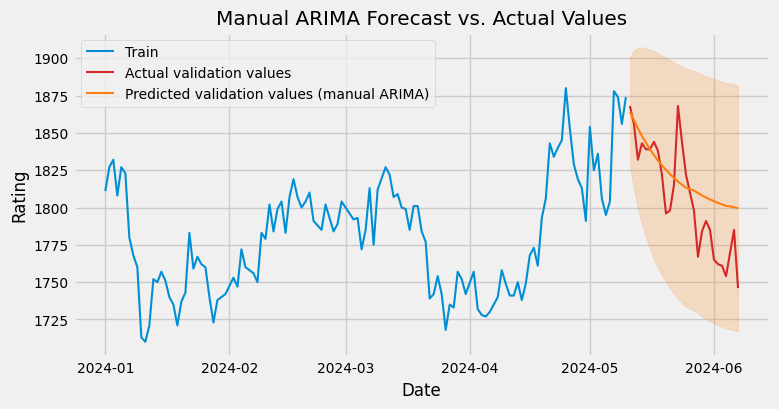

In [21]:
from statsmodels.tsa.arima.model import ARIMA

def eval_arima(p,d,q):
    history = train.dropna().tolist()
    preds = []
    for actual in test.dropna():
        m = ARIMA(history, order=(p,d,q))
        f = m.fit()
        yhat = f.forecast()[0]
        preds.append(yhat)
        history.append(actual)
    return mean_squared_error(test.dropna(), preds)

best_mse, best_order = float("inf"), None
for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                mse = eval_arima(p,d,q)
                if mse < best_mse:
                    best_mse, best_order = mse, (p,d,q)
            except:
                pass

print('Best ARIMA(p,d,q)=', best_order, 'MSE=', best_mse)
model_arima = ARIMA(train, order=best_order).fit()
print(model_arima.summary())

fc_manual = model_arima.get_forecast(steps=len(valid))
mean_manual = fc_manual.predicted_mean
conf_manual = fc_manual.conf_int()

plt.figure(figsize=(8,4))
plt.plot(train.index, train, label='Train')
plt.plot(valid.index, valid, label='Actual validation values', color='tab:red')
plt.plot(valid.index, mean_manual, label='Predicted validation values (manual ARIMA)', color='tab:orange')
plt.fill_between(valid.index,
                 conf_manual.iloc[:,0],
                 conf_manual.iloc[:,1],
                 color='tab:orange', alpha=0.2)
plt.title('Manual ARIMA Forecast vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.legend()
plt.show()

The best-performing ARIMA model identified corresponds to an AR(2) specification without differencing or a moving average component. The plot shows that the ARIMA(2,0,0) model produces a downward-sloping forecast curve with widening confidence bands, partially capturing the dynamics observed in the validation set.

### Uso de auto_arima

To automate the identification of the optimal ARIMA model according to an information criterion (AIC), the `pm.auto_arima` function is employed with a stepwise search procedure.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2192.394, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1088.938, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1091.697, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1090.842, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1091.882, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1079.508, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1174.329, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1079.277, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1256.173, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1079.393, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1081.389, T

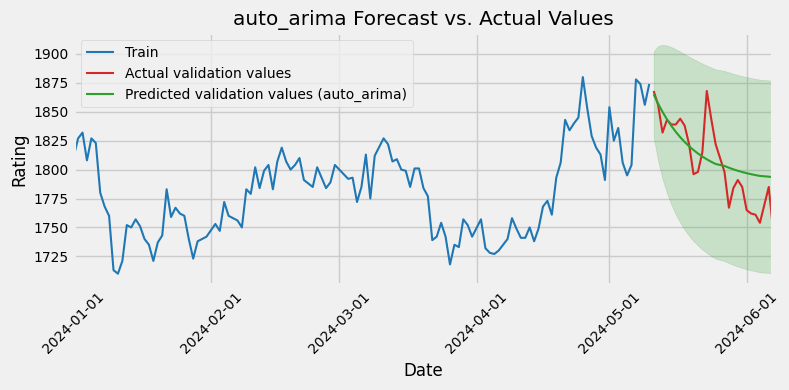

In [22]:
# Automatic model fitting
auto = pm.auto_arima(
    train.dropna(),
    start_p=0, start_q=0,
    max_p=2,    max_q=2,
    d=None,             # automatically detect d
    seasonal=False,
    trace=True,
    error_action='ignore'
)
print(auto.summary())

# Use the Statsmodels object created by auto_arima
res_auto = auto.arima_res_

# Generate the forecast and the corresponding confidence intervals
fc_auto = res_auto.get_forecast(steps=len(valid))
mean_auto = fc_auto.predicted_mean
conf_auto = fc_auto.conf_int()

# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train.index, train,                 label='Train',      color='tab:blue')
ax.plot(valid.index, valid,                 label='Actual validation values', color='tab:red')
ax.plot(valid.index, mean_auto,             label='Predicted validation values (auto_arima)', color='tab:green')
ax.fill_between(
    valid.index,
    conf_auto.iloc[:,0],
    conf_auto.iloc[:,1],
    color='tab:green', alpha=0.2
)

ax.set_title('auto_arima Forecast vs. Actual Values')
ax.set_xlabel('Date')
ax.set_ylabel('Rating')
ax.set_xlim(train.index.min(), valid.index.max())
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In this process, ARIMA models with $p \leq 2$ and $q \leq 2$ were evaluated, and the optimal specification identified was ARIMA(1,0,0) with an intercept, yielding an AIC of 1079.277.

When generating the forecast and its confidence intervals, the predicted curve (green line) displays a slight downward trajectory. The uncertainty bands widen as the forecasting horizon increases, reflecting the accumulation of variance over time, which is standard behavior in ARIMA models. Compared with the actual validation data (red line), the automated model captures the general downward trend observed in May-June, although it does not reproduce the intermediate peaks.

The manually selected model favored AR(2) because it directly minimized the MSE on the validation set, but its AIC was less competitive. In contrast, `auto_arima`, by optimizing the AIC criterion, proposes a more parsimonious model (p = 1) that reduces model complexity at the cost of a slightly less accurate fit to the peaks. In practice, the choice between the two approaches depends on the objective: minimizing forecasting error (manual selection) versus balancing fit and complexity (automatic selection).

## Conclusions

The analysis of the Blitz rating time series on Lichess reveals a combined behavior of trend, seasonality, and noise. Through classical decomposition using a monthly period (30 days), a growing trend was isolated (with a trough in early February and a peak in April-May), along with a weak seasonal pattern of moderate amplitude ($\pm$15 points). The resulting residuals, which exhibited homogeneous variance and no apparent structure, confirmed that most of the series’ dynamics are concentrated in these two components.

The stationarity tests (ACF, PACF, variogram, and Dickey–Fuller) demonstrated that **the original series is non-stationary**: the ACF decays slowly, the variogram does not converge, and the ADF statistic does not exceed the critical values at the 10 percent level. After applying first-order differencing, the transformed series oscillated around zero without a trend, the ACF of the differenced series remained within the confidence bounds, and the PACF displayed a single significant lag at k = 1. These results indicate the suitability of a low-order integrated model.

Regarding smoothing methods, the centered moving average (7-day window) produced a validation error (MSE $\approx$ 234) that was substantially lower than the training error (MSE $\approx$ 500), indicating effective tracking capability during periods of moderate volatility. Simple exponential smoothing ($\alpha$ = 0.3) balanced responsiveness to changes with noise filtering, adapting rapidly to the increases observed in April and June. Holt’s method captured the underlying trend more faithfully, although it tended to underestimate the more abrupt peaks. Finally, the manually selected ARIMA model (2,0,0) and the auto_arima model (1,0,0) offered complementary perspectives: the former minimized out-of-sample MSE directly, whereas the latter optimized AIC to achieve a more parsimonious specification. Taken together, these findings allow for selecting the method or combination of methods according to the forecasting horizon and the desired balance between accuracy and complexity.